In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_pk_constraint('station')
columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


{'constrained_columns': ['id'], 'name': None}

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

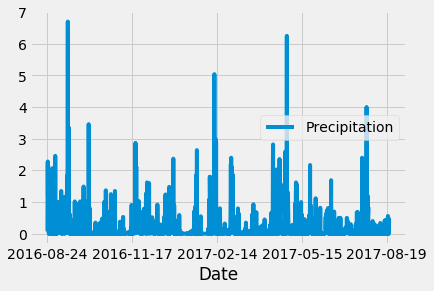

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
rain_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(rain_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df = precipitation_df.dropna()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot().get_figure()
ax.savefig("Output/Precipitation_last_12months.png")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Station)
print("There are {} stations.".format(locations.count()))

There are 9 stations.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations_descending = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station_name = ""
most_active_station = active_stations_descending[0][0]

for location in locations:
    if(location.station == active_stations_descending[0][0]):
        most_active_station_name = location.name 
print(f"The most active stations information: ")
print(f" Name    : {most_active_station_name} ")
print(f" Station : {active_stations_descending[0][0]}")
print(f" Count   : {active_stations_descending[0][1]}")
print("")
print("List of the stations and the counts in descending order:")
print("Station        Counts")
print("-----------------------")
for active_station_descending in active_stations_descending:
    print(active_station_descending[0], "   ", active_station_descending[1])


The most active stations information: 
 Name    : WAIHEE 837.5, HI US 
 Station : USC00519281
 Count   : 2772

List of the stations and the counts in descending order:
Station        Counts
-----------------------
USC00519281     2772
USC00519397     2724
USC00513117     2709
USC00519523     2669
USC00516128     2612
USC00514830     2202
USC00511918     1979
USC00517948     1372
USC00518838     511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperature_frequencies = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"The Lowest, Highest & the average temperature for most active station {most_active_station} is :")
print(f" Low  : {temperature_frequencies[0][0]}")
print(f" High : {temperature_frequencies[0][1]}")
print(f" Avg  : {temperature_frequencies[0][2]}")

The Lowest, Highest & the average temperature for most active station USC00519281 is :
 Low  : 54.0
 High : 85.0
 Avg  : 71.66378066378067


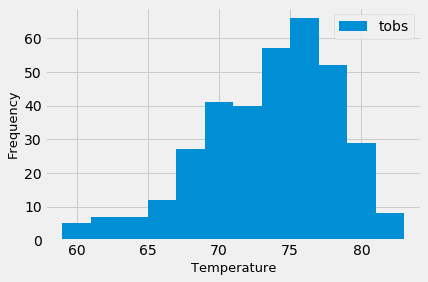

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).filter(Measurement.date >= last_year).\
    group_by(Measurement.date).all()

# Put data into dataframe so it can be plotted as histogram
temp_results_df = pd.DataFrame(data=temp_results, columns=["date", "tobs"])
temp_results_df = temp_results_df.set_index('date', drop=True)

#Plot the results as a histogram with bins=12
plt.hist(temp_results_df['tobs'],12, label="tobs")
plt.xlabel("Temperature", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.legend()
plt.savefig("Output/Temperature_for_active station_last_12months.png")
plt.show()



## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    select = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*select).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
data = calc_temps((trip_arrive-last_year), (trip_leave-last_year))

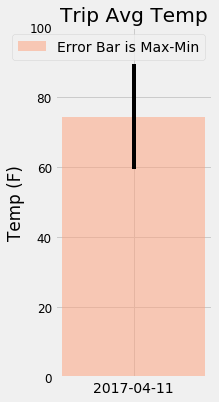

In [20]:
# Plot the results from your previous query as a bar chart. 
bar_trip_df = pd.DataFrame(data=data, columns=["date","tmin", "tavg", "tmax"])
bar_trip_df = bar_trip_df.set_index('date', drop=True)
plot_date = bar_trip_df.index.values
plot_tmin = bar_trip_df['tmin']
plot_tavg = bar_trip_df['tavg']
plot_tmax = bar_trip_df['tmax']

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
diff = bar_trip_df['tmax'] - bar_trip_df['tmin']
plt.figure(figsize=[2.5, 6])
pavg = plt.bar(plot_date, plot_tavg, yerr=diff, color="lightsalmon", alpha=.5, label="Error Bar is Max-Min")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.legend()
plt.yticks(np.arange(0, 120, 20), fontsize=12)
plt.savefig("Output/Bar_MyTrip_Avg_Temp.png")
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
